In [8]:
from pathlib import Path

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from layouts import Layout
from layouts.library import surface_code
from layouts.util.mixed import set_freq_groups, set_transmon_target_freqs, set_fluxonia_target_energies, sample_params, get_collisions

# Distance-3 surface code

In [9]:
DISTANCE = 5

layout = surface_code(DISTANCE, mixed_layout=True)
set_freq_groups(layout)

GROUP_FREQS = np.array([4.4, 4.8, 5.2, 5.6]) # Following IBM definitions
GROUP_ANHARMS = np.repeat(-0.3, len(GROUP_FREQS))
set_transmon_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

set_fluxonia_target_energies(layout, target_induct_energy=1, target_joseph_energy=4)

sample_params(layout, seed=0, resist_var=0)

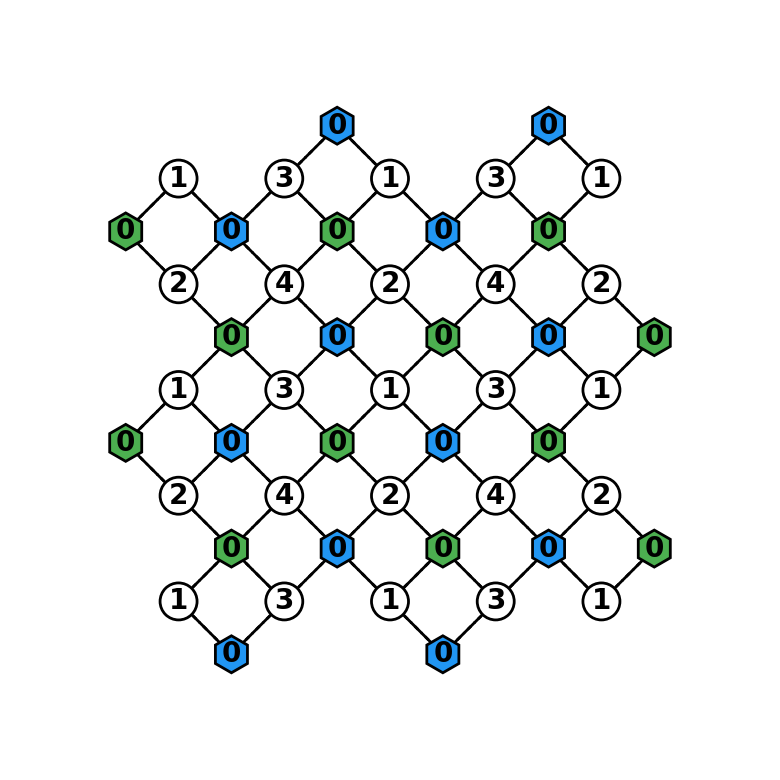

In [10]:
fig, ax = plt.subplots(dpi=200)

layout.plot(param_label="freq_group", axis=ax)
plt.tight_layout()
plt.show()

In [11]:
%%timeit
sample_params(layout, seed = 5, resist_var = 1e-2)
_ = get_collisions(layout)

484 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Scan for distance 3

In [12]:
MAX_RES_VAR = 8e-2
NUM_RES_VARS = 20
NUM_SEEDS = 1000

RES_VARS = np.geomspace(1e-3, MAX_RES_VAR, NUM_RES_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

In [11]:
sampled_collisions = np.zeros((NUM_RES_VARS, NUM_SEEDS, 3), dtype=int)

for var_ind, res_var in enumerate(RES_VARS):
    for seed_ind, seed in enumerate(SEEDS):
        sample_params(layout, seed, res_var)
        sampled_collisions[var_ind, seed_ind] = get_collisions(layout)

In [12]:
total_collisions = sampled_collisions.sum(axis = 2)
collision_stats = sampled_collisions.sum(axis = 1)
device_yield = np.mean(total_collisions == 0, axis= 1)

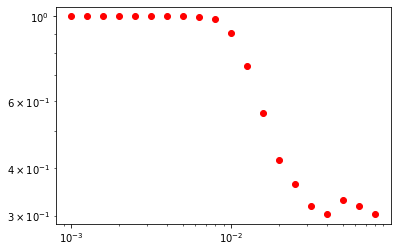

In [13]:
fig, ax = plt.subplots()

ax.scatter(RES_VARS, device_yield, color="red")
ax.set_xscale("log")
ax.set_yscale("log")

plt.show()

# Scan with distance as well

In [23]:
notebook_dir = Path.cwd()
data_folder = notebook_dir / "data"
data_folder.mkdir(parents=True, exist_ok=True)

In [13]:
MAX_RES_VAR = 2e-2
NUM_RES_VARS = 10
NUM_SEEDS = 10000

DISTANCES = [3, 5, 7]
RES_VARS = np.geomspace(1e-3, MAX_RES_VAR, NUM_RES_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

In [25]:

for dist_ind, distance in enumerate(DISTANCES):
    sampled_collisions = np.zeros((NUM_RES_VARS, NUM_SEEDS, 3), dtype=int)
    layout = surface_code(distance, mixed_layout=True)
    
    set_freq_groups(layout)
    set_transmon_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)
    set_fluxonia_target_energies(layout, target_induct_energy=1, target_joseph_energy=4)

    for var_ind, res_var in enumerate(RES_VARS):
        for seed_ind, seed in enumerate(SEEDS):
            sample_params(layout, seed, res_var)
            sampled_collisions[var_ind, seed_ind] = get_collisions(layout)
            
    collisions = xr.DataArray(
        sampled_collisions,
        dims = ["resist_var", "seed", "collision_type"],
        coords = dict(
            distance = distance,
            resist_var = RES_VARS,
            seed = SEEDS,
            collision_type = ["address", "cross_res", "spectator"]
        )
    )
    
    data_arr_name = f"mixed_device_yield_d_{distance}_rn_{MAX_RES_VAR}_seeds_{NUM_SEEDS}.nc"
    collisions.to_netcdf(data_folder/data_arr_name)

KeyboardInterrupt: 

In [15]:
_collisions = []

notebook_dir = Path.cwd()
data_folder = notebook_dir / "data"
data_folder.mkdir(parents=True, exist_ok=True)
    
for distance in [3, 5]:
    data_arr_name = f"mixed_device_yield_d_{distance}_rn_{MAX_RES_VAR}_seeds_{NUM_SEEDS}.nc"
    dist_arr = xr.load_dataarray(data_folder/data_arr_name)
    _collisions.append(dist_arr)
    
collisions = xr.concat(_collisions, dim="distance")

In [16]:
total_collisions = collisions.sum(dim="collision_type")
collision_stats = collisions.sum(dim="seed")

zero_collision_runs = xr.where(total_collisions == 0, 1, 0)
device_yield = zero_collision_runs.mean(dim="seed")

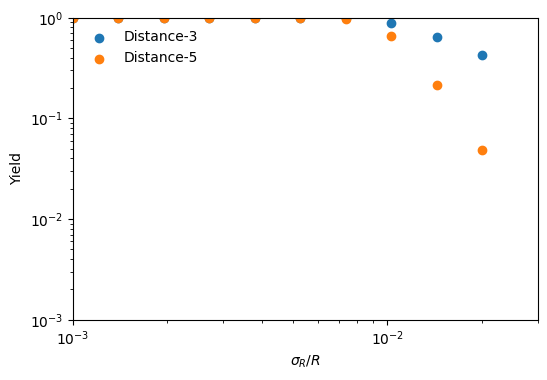

In [17]:
fig, ax = plt.subplots(dpi=100)

for dist in device_yield.distance.values:
    label = f"Distance-{dist}"
    ax.scatter(
        device_yield.resist_var, 
        device_yield.sel(distance=dist),
        label=label,
    )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{R}/R$")
ax.set_ylabel(r"Yield")
ax.set_yscale("log")
ax.set_ylim(1e-3, 1)
ax.set_xlim(1e-3, 3e-2)
ax.legend(frameon=False)

plt.show()

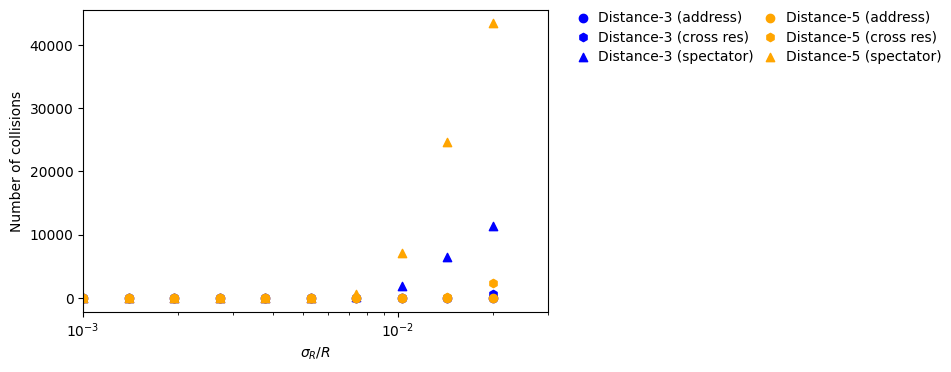

In [31]:
fig, ax = plt.subplots(dpi=100)

markers = dict(
    address = "o",
    cross_res = "h",
    spectator = "^"
)

colors = dict(dist_3 = "blue", dist_5 = "orange", dist_7 = "green")

for dist in collision_stats.distance.values:
    color = colors[f"dist_{dist}"]
    for col_type in collision_stats.collision_type.values:
        
        col_label = "cross res" if col_type == "cross_res" else col_type
        label = f"Distance-{dist} ({col_label})"
        ax.scatter(
            collision_stats.resist_var, 
            collision_stats.sel(distance=dist, collision_type=col_type),
            label=label,
            color=color,
            marker = markers[col_type]
        )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{R}/R$")
ax.set_ylabel(r"Number of collisions")
ax.set_xlim(1e-3, 3e-2)
ax.legend(
    frameon=False, 
    ncol=2,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    borderpad=0,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4
)

plt.show()

In [177]:
SAVE_DATA = False

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    data_arr_name = f"tmon_tmob_yield_scan_dist_{*DISTANCES,}_max_var_{MAX_FREQ_VAR}_seeds_{NUM_SEEDS}.nc"
    collisions.to_netcdf(data_folder/data_arr_name)